## **Import and install requirements**

In [ ]:
import numpy as np
import copy
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
pip install networkx matplotlib

## **Evaluation function**

In [ ]:
pip install cdlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 32.5 MB/s eta 0:00:00


In [ ]:
import networkx as nx
from cdlib.utils import convert_graph_formats
from collections import defaultdict
from collections import namedtuple



def modularity_overlap_signed_new(
    graph: nx.Graph, communities: list, weight: str = None
):
    """Determines the Overlapping Modularity of a partition C on a graph G for signed networks.

    Overlapping Modularity for signed networks is defined as

     .. math:: Q_{c_{r}}^{ov} = \\frac{1}{2m^+ + 2m^-} \\sum_{i,j} \\frac{1}{O_i O_j} [A_{ij} - \\left(\\frac{d_i^+ d_j^+}{2m^+} - \\frac{d_i^- d_j^-}{2m^-}\\right)] \\delta(i, j)

    where:
        - \(A_{ij}\) is the weight of the edge between nodes \(i\) and \(j\),
        - \(d_i^+\) and \(d_i^-\) are the positive and negative degrees of node \(i\), respectively,
        - \(2m^+\) and \(2m^-\) are the sums of weights of positive and negative edges in the network, respectively,
        - \(O_i\) and \(O_j\) are the number of communities which include vertex \(i\) and \(j\) respectively,
        - \(\delta(i, j)\) is the Kronecker delta function, equals to 1 when both nodes \(i\) and \(j\) belong to the same community, and 0 otherwise.

    :param graph: a networkx/igraph object
    :param communities: NodeClustering object
    :param weight: label identifying the edge weight parameter name (if present), default None
    :return: FitnessResult object

    """
    FitnessResult = namedtuple("FitnessResult", "score")
    graph = convert_graph_formats(graph, nx.Graph)
    E = len(graph.edges)
    # print('E:',E)

    # Calculate positive and negative degrees
    pos_degrees = {node: 0 for node in graph.nodes()}
    neg_degrees = {node: 0 for node in graph.nodes()}
    for u, v, data in graph.edges(data=True):
        s = data.get('sign')
        if s > 0:
          pos_degrees[u]+=1
          pos_degrees[v]+=1
        else:
          neg_degrees[u]+=1
          neg_degrees[v]+=1

    # print('neg degree:',neg_degrees)
    # print('pos degree:',pos_degrees)

    # Calculate total edge weight for positive and negative edges separately
    total_pos_edge_weight = sum(s for u, v, s in graph.edges(data='sign') if s >= 0)
    # print('pos total:',total_pos_edge_weight)
    total_neg_edge_weight = sum(abs(s) for u, v, s in graph.edges(data='sign') if s < 0)
    # print('neg total:',total_neg_edge_weight)

    m_pos = total_pos_edge_weight / 2
    m_neg = total_neg_edge_weight / 2

    QovTotal = 0

    for nodes in communities:
        nCommNodes = len(nodes)

        # the contribution of communities with 1 node is 0
        if nCommNodes <= 1:
            continue

        for i in range(nCommNodes):
            for j in range(i+1, nCommNodes):
                node_i = nodes[i]
                node_j = nodes[j]

                # Calculate the Kronecker delta
                delta = 1 if node_i in nodes and node_j in nodes else 0

                # Calculate O_i and O_j
                Oi = len([c for c in communities if node_i in c])
                Oj = len([c for c in communities if node_j in c])

                # Calculate the modularity contribution
                # print(f"node1:{node_i}\nnode2:{node_j}")
                # a = graph.get_edge_data(node_i, node_j, default={'sign': 0}).get('sign',0)
                # b = (pos_degrees[node_i] * pos_degrees[node_j]) / (2 * E)
                # c = (neg_degrees[node_i] * neg_degrees[node_j]) / (2 * E)
                # d = 1 / (Oi * Oj)
                # print(f"a:{a}\nb:{b}\nc:{c}\nd:{d}")
                mod_contrib = ((graph.get_edge_data(node_i, node_j, default={'sign': 0}).get('sign',0)) -
                               (((pos_degrees[node_i] * pos_degrees[node_j]) / (2 * E)) -
                               ((neg_degrees[node_i] * neg_degrees[node_j]) / (2 * E)))) * (1 / (Oi * Oj))
                # print(f"mod:{mod_contrib}")

                QovTotal += mod_contrib * delta

    QovTotal /= (2 * m_pos + 2 * m_neg)

    return FitnessResult(score=QovTotal)


## **Read Datasets & generate graph & vizualize them**

In [ ]:
# import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Highland Tribes dataset**

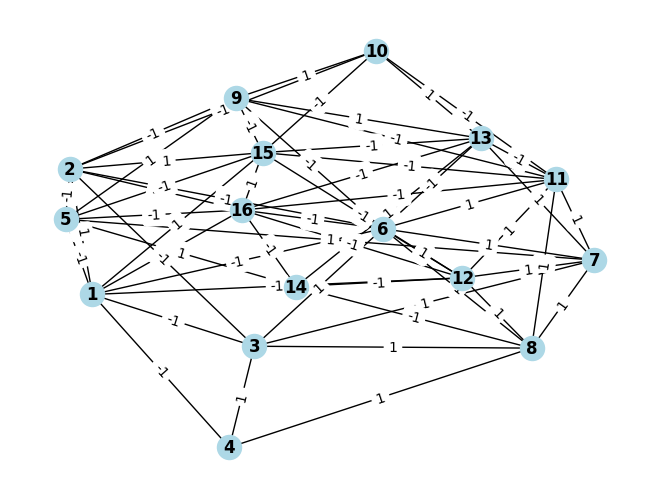

In [ ]:
highland_graph = nx.Graph()

with open("/content/drive/MyDrive/out.ucidata-gama", 'r') as file:
  lines = file.readlines()

# Skip the first two lines as they contain metadata
for line in lines[2:]:
    # Split the line into tokens
    tokens = line.strip().split('\t')

    # Extract nodes and sign from the tokens
    node1, node2, sign = int(tokens[0]), int(tokens[1]), int(tokens[2])

    # Add the edge with the sign
    highland_graph.add_edge(node1, node2, sign=sign)

# Draw the signed graph
pos = nx.spring_layout(highland_graph)
edge_labels = {(i, j): f"{highland_graph[i][j]['sign']}" for i, j in highland_graph.edges()}

nx.draw(highland_graph, pos, with_labels=True, font_weight='bold', node_color='lightblue')
nx.draw_networkx_edge_labels(highland_graph, pos, edge_labels=edge_labels)

plt.show()

### **Pajek dataset**

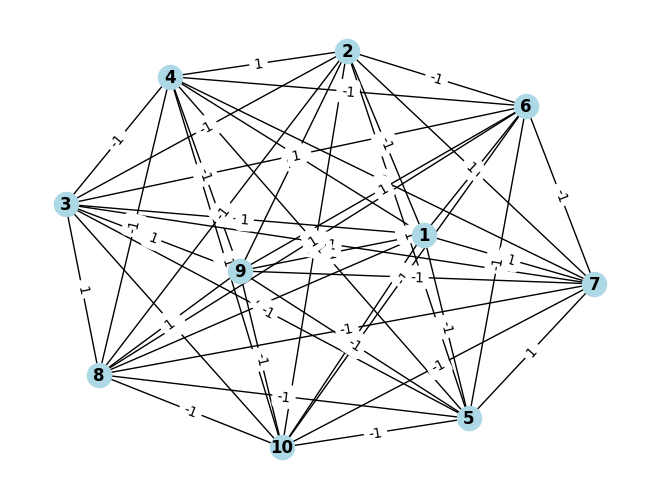

In [ ]:
pajek_graph = nx.Graph()

with open("/content/drive/MyDrive/pajek-dataset.txt", 'r') as file:
  lines = file.readlines()

# Skip the first two lines as they contain metadata
for line in lines[:-1]:
    # Split the line into tokens
    tokens = line.strip().split('\t')

    # Extract nodes and sign from the tokens
    node1, node2, sign = int(tokens[0]), int(tokens[1]), int(tokens[2])

    # Add the edge with the sign
    pajek_graph.add_edge(node1, node2, sign=sign)


# Draw the signed graph
pos = nx.spring_layout(pajek_graph)
edge_labels = {(i, j): f"{pajek_graph[i][j]['sign']}" for i, j in pajek_graph.edges()}

nx.draw(pajek_graph, pos, with_labels=True, font_weight='bold', node_color='lightblue')
nx.draw_networkx_edge_labels(pajek_graph, pos, edge_labels=edge_labels)

plt.show()


## **Weighting graphs with Jaccard method**

In [ ]:
#weighting graph function
def weight_graph(G):
  for u in list(G.nodes):
    u_pos = [u]
    u_neg = []
    for e in G[u].keys():
      if G[u][e]['sign'] == 1:
        u_pos.append(e)
      else:
        u_neg.append(e)

    for v in list(G.nodes):
      if G.has_edge(u,v) and u!=v:
        v_pos = [v]
        v_neg = []
        for e in G[v].keys():
          if G[v][e]['sign'] == 1:
            v_pos.append(e)
          else:
            v_neg.append(e)

        N_u = u_pos + u_neg
        N_v = v_pos + v_neg
        s_pos = float(len(set(u_pos).intersection(set(v_pos)))) + float(len(set(u_neg).intersection(set(v_neg))))
        s_neg = float(len(set(u_pos).intersection(set(v_neg)))) + float(len(set(u_neg).intersection(set(v_pos))))
        sim = (s_pos - s_neg) / float(len(set(N_u).union(set(N_v))))
        G[u][v]['weight'] = sim

        # print(f"weight between {u} and {v}: {G[u][v]['weight']}")
        # print('----------------------------------')

In [ ]:
#weighting highland dataset
weight_graph(highland_graph)

#weighting Pajek dataset
weight_graph(pajek_graph)

# **Main SLPA**

In [ ]:
def slpa_nx(G, T, r):
    """
    Speaker-Listener Label Propagation Algorithm (SLPA)
    see http://arxiv.org/abs/1109.5720
    """

    # Stage 1: Initialization
    memory = {i: {i: 1} for i in G.nodes()}

    # Stage 2: Evolution
    for t in range(T):

        listeners_order = list(G.nodes())
        np.random.shuffle(listeners_order)

        for listener in listeners_order:
            speakers = G[listener].keys()
            if len(speakers) == 0:
                continue

            labels = defaultdict(int)

            for j, speaker in enumerate(speakers):
                # Speaker Rule
                total = float(sum(memory[speaker].values()))
                labels[
                    list(memory[speaker].keys())[
                        np.random.multinomial(
                            1, [freq / total for freq in memory[speaker].values()]
                        ).argmax()
                    ]
                ] += 1

            # Listener Rule
            accepted_label = max(labels, key=labels.get)

            # Update listener memory
            if accepted_label in memory[listener]:
                memory[listener][accepted_label] += 1
            else:
                memory[listener][accepted_label] = 1

    # Stage 3:
    for node, mem in memory.items():
        its = copy.copy(list(mem.items()))
        for label, freq in its:
            if freq / float(T + 1)  <  r:
                del mem[label]

    # Find nodes membership
    communities = {}
    for node, mem in memory.items():
        for label in mem.keys():
            if label in communities:
                communities[label].add(node)
            else:
                communities[label] = {node}

    # Remove nested communities
    nested_communities = set()
    keys = list(communities.keys())
    for i, label0 in enumerate(keys[:-1]):
        comm0 = communities[label0]
        for label1 in keys[i + 1 :]:
            comm1 = communities[label1]
            if comm0.issubset(comm1):
                nested_communities.add(label0)
            elif comm0.issuperset(comm1):
                nested_communities.add(label1)

    for comm in nested_communities:
        del communities[comm]

    return [list(c) for c in communities.values()]


## **Ideas to change SLPA for sigend networks**

### **Ideas without considering edges weights**

### **idea #1**

In [ ]:
def signed_slpa_v1(G, T, r):
    """
    Speaker-Listener Label Propagation Algorithm (SLPA)
    see http://arxiv.org/abs/1109.5720
    """

    # Stage 1: Initialization
    memory = {i: {i: 1} for i in G.nodes()}

    # Stage 2: Evolution
    for t in range(T):

        listeners_order = list(G.nodes())
        np.random.shuffle(listeners_order)

        for listener in listeners_order:
            speakers = G[listener].keys()
            if len(speakers) == 0:
                continue

            labels = defaultdict(int)

            for j, speaker in enumerate(speakers):
                # Speaker Rule: Based on the sign of edge between speaker and listener
                total = float(sum(memory[speaker].values()))
                if G[listener][speaker]['sign'] == 1:
                    labels[
                        list(memory[speaker].keys())[
                            np.random.multinomial(
                                1, [freq / total for freq in memory[speaker].values()]
                            ).argmax()
                        ]
                    ] += 1

                else:
                    labels[
                        list(memory[speaker].keys())[
                            np.random.multinomial(
                                1, [freq / total for freq in memory[speaker].values()]
                            ).argmax()
                        ]
                    ] -= 1


            # Listener Rule
            accepted_label = max(labels, key=labels.get)

            # Update listener memory
            if accepted_label in memory[listener]:
                memory[listener][accepted_label] += 1
            else:
                memory[listener][accepted_label] = 1

    # Stage 3:
    for node, mem in memory.items():
        its = copy.copy(list(mem.items()))
        for label, freq in its:
            if freq / float(T + 1)  <  r:
                del mem[label]

    # Find nodes membership
    communities = {}
    for node, mem in memory.items():
        for label in mem.keys():
            if label in communities:
                communities[label].add(node)
            else:
                communities[label] = {node}

    # Remove nested communities
    nested_communities = set()
    keys = list(communities.keys())
    for i, label0 in enumerate(keys[:-1]):
        comm0 = communities[label0]
        for label1 in keys[i + 1 :]:
            comm1 = communities[label1]
            if comm0.issubset(comm1):
                nested_communities.add(label0)
            elif comm0.issuperset(comm1):
                nested_communities.add(label1)

    for comm in nested_communities:
        del communities[comm]

    return [list(c) for c in communities.values()]

**implement idea #1 on datasets**

In [ ]:
#implement idea #1 on highland dataset
highland_coms_1 = signed_slpa_v1(highland_graph,21,r=0.1)
print(highland_coms_1)

[[16, 1, 2, 15], [3, 4, 5, 6, 7, 8, 11, 12], [5, 9, 10, 13, 14]]


In [ ]:
#implement idea #1 on pajek dataset
pajek_coms_1 = signed_slpa_v1(pajek_graph,21,r=0.1)
print(pajek_coms_1)

[[1, 3, 6, 8, 9], [2, 4, 5, 7, 10]]


**Evaluation idea #1 algorithm on datasets**

In [ ]:
#evaluation idea #1 on highland dataset
modularity_overlap_signed_new(highland_graph, highland_coms_1)

FitnessResult(score=0.43467598097502974)

In [ ]:
#evaluation idea #1 on pajek dataset
modularity_overlap_signed_new(pajek_graph, pajek_coms_1)

FitnessResult(score=0.4355555555555554)

### **idea #2**

In [ ]:
def signed_slpa_v2(G, T, r):
    """
    Speaker-Listener Label Propagation Algorithm (SLPA)
    see http://arxiv.org/abs/1109.5720
    """

    # Stage 1: Initialization
    memory = {i: {i: 1} for i in G.nodes()}

    # Stage 2: Evolution
    for t in range(T):

        listeners_order = list(G.nodes())
        np.random.shuffle(listeners_order)

        for listener in listeners_order:
            neg_speakers = []
            pos_speakers = []
            for e in G[listener].keys():
                if G[listener][e]['sign'] == 1:
                    pos_speakers.append(e)
                else:
                    neg_speakers.append(e)


            if (len(neg_speakers) == 0) and (len(pos_speakers)==0):
              print(neg_speakers)
              print(pos_speakers)
              continue

            neg_labels = defaultdict(int)
            pos_labels = defaultdict(int)

            for j, speaker in enumerate(neg_speakers):
                # Speaker Rule
                total = 0
                for value in memory[speaker].values():
                  if value > 0:
                    total+=value

                neg_labels[
                    list(memory[speaker].keys())[
                        np.random.multinomial(
                            1, [freq / total for freq in memory[speaker].values() if freq>0]
                        ).argmax()
                    ]
                ] += 1



            for j, speaker in enumerate(pos_speakers):
                # Speaker Rule
                # total = float(sum(memory[speaker].values()))
                total = 0
                for value in memory[speaker].values():
                  if value > 0:
                    total+=value

                pos_labels[
                    list(memory[speaker].keys())[
                        np.random.multinomial(
                            1, [freq / total for freq in memory[speaker].values() if freq>0]
                        ).argmax()
                    ]
                ] += 1



            # Listener Rule
            if neg_labels:
              rejected_label = max(neg_labels, key=neg_labels.get)

            if pos_labels:
              accepted_label = max(pos_labels, key=pos_labels.get)


            # Update listener memory
            if rejected_label in memory[listener]:
                memory[listener][rejected_label] -= 1
            else:
                memory[listener][rejected_label] = -1


            if accepted_label in memory[listener]:
                memory[listener][accepted_label] += 1
            else:
                memory[listener][accepted_label] = 1

    # Stage 3:
    for node, mem in memory.items():
        its = copy.copy(list(mem.items()))
        for label, freq in its:
            if freq / float(T + 1)  <  r:
                del mem[label]

    # Find nodes membership
    communities = {}
    for node, mem in memory.items():
        for label in mem.keys():
            if label in communities:
                communities[label].add(node)
            else:
                communities[label] = {node}

    # Remove nested communities
    nested_communities = set()
    keys = list(communities.keys())
    for i, label0 in enumerate(keys[:-1]):
        comm0 = communities[label0]
        for label1 in keys[i + 1 :]:
            comm1 = communities[label1]
            if comm0.issubset(comm1):
                nested_communities.add(label0)
            elif comm0.issuperset(comm1):
                nested_communities.add(label1)

    for comm in nested_communities:
        del communities[comm]

    return [list(c) for c in communities.values()]

**implement idea #2 on datasets**

In [ ]:
#implement idea #2 on highland dataset
highland_coms_2 = signed_slpa_v2(highland_graph, 50,r=0.1)
print(highland_coms_2)

[[16, 1, 10, 13], [1, 4, 6, 8, 11, 15, 16], [1, 2, 9, 10, 14], [3, 7, 8, 11, 14, 15, 16], [3, 5, 6, 12, 13], [5, 14], [8, 11, 12, 7]]


In [ ]:
#implement idea #2 on pajek dataset
pajek_coms_2 = signed_slpa_v2(pajek_graph,50,r=0.1)
print(pajek_coms_2)

[[8, 1, 6, 9], [2, 4, 5, 7, 10]]


**Evaluation idea #2 algorithm on datasets**

In [ ]:
#evaluation idea #1 on highland dataset
modularity_overlap_signed_new(highland_graph, highland_coms_2)

FitnessResult(score=0.030457292905271507)

In [ ]:
#evaluation idea #2 on pajek dataset
modularity_overlap_signed_new(pajek_graph, pajek_coms_2)

FitnessResult(score=0.3377777777777778)

### **Ideas with considering edges weights**

### **idea #3**

In [ ]:
def signed_slpa_v3(G, T, r):
    """
    Speaker-Listener Label Propagation Algorithm (SLPA)
    see http://arxiv.org/abs/1109.5720
    """

    # Stage 1: Initialization
    memory = {i: {i: 1} for i in G.nodes()}

    # Stage 2: Evolution
    for t in range(T):

        listeners_order = list(G.nodes())
        np.random.shuffle(listeners_order)

        for listener in listeners_order:
            speakers = G[listener].keys()
            if len(speakers) == 0:
                continue

            labels = defaultdict(int)

            for j, speaker in enumerate(speakers):
                # Speaker Rule
                total = float(sum(memory[speaker].values()))
                labels[
                    list(memory[speaker].keys())[
                        np.random.multinomial(
                            1, [freq / total for freq in memory[speaker].values()]
                        ).argmax()
                    ]
                ] += G[listener][speaker]['weight']


            # Listener Rule
            accepted_label = max(labels, key=labels.get)

            # Update listener memory
            if accepted_label in memory[listener]:
                memory[listener][accepted_label] += 1
            else:
                memory[listener][accepted_label] = 1

    # Stage 3:
    for node, mem in memory.items():
        its = copy.copy(list(mem.items()))
        for label, freq in its:
            if freq / float(T + 1)  <  r:
                del mem[label]

    # Find nodes membership
    communities = {}
    for node, mem in memory.items():
        for label in mem.keys():
            if label in communities:
                communities[label].add(node)
            else:
                communities[label] = {node}

    # Remove nested communities
    nested_communities = set()
    keys = list(communities.keys())
    for i, label0 in enumerate(keys[:-1]):
        comm0 = communities[label0]
        for label1 in keys[i + 1 :]:
            comm1 = communities[label1]
            if comm0.issubset(comm1):
                nested_communities.add(label0)
            elif comm0.issuperset(comm1):
                nested_communities.add(label1)

    for comm in nested_communities:
        del communities[comm]

    return [list(c) for c in communities.values()]


**implement idea #3 on datasets**

In [ ]:
#implement idea #3 on highland dataset
highland_coms_3 = signed_slpa_v3(highland_graph, 21, r=0.1)
print(highland_coms_3)

[[16, 1, 2, 15], [3, 4, 6, 7, 8, 11, 12], [5, 9, 10, 13, 14]]


In [ ]:
#implement idea #3 on pajek dataset
pajek_coms_3 = signed_slpa_v3(pajek_graph, 21, r=0.1)
print(pajek_coms_3)

[[1, 3, 6, 8, 9], [2, 4, 5, 7, 10]]


**Evaluation idea #3 algorithm on datasets**

In [ ]:
#evaluation idea #3 on highland dataset
modularity_overlap_signed_new(highland_graph, highland_coms_3)

FitnessResult(score=0.4467895362663496)

In [ ]:
#evaluation idea #3 on pajek dataset
modularity_overlap_signed_new(pajek_graph, pajek_coms_3)

FitnessResult(score=0.4355555555555554)

### **idea #4**

In [ ]:
def signed_slpa_v4(G, T, r):
    """
    Speaker-Listener Label Propagation Algorithm (SLPA)
    see http://arxiv.org/abs/1109.5720
    """

    # Stage 1: Initialization
    memory = {i: {i: 1} for i in G.nodes()}

    # Stage 2: Evolution
    for t in range(T):

        listeners_order = list(G.nodes())
        np.random.shuffle(listeners_order)

        for listener in listeners_order:
            speakers = G[listener].keys()
            if len(speakers) == 0:
                continue

            labels = defaultdict(int)

            for j, speaker in enumerate(speakers):
                # Speaker Rule
                total = float(sum(memory[speaker].values()))
                labels[
                    list(memory[speaker].keys())[
                        np.random.multinomial(
                            1, [freq / total for freq in memory[speaker].values()]
                        ).argmax()
                    ]
                ] += G[listener][speaker]['weight']


            # Listener Rule
            accepted_label = max(labels, key=labels.get)
            labels_freq = list(labels.values())
            accepted_label_freq = labels[accepted_label]

            # Update listener memory
            if accepted_label in memory[listener]:
                memory[listener][accepted_label] +=accepted_label_freq
            else:
                memory[listener][accepted_label] = accepted_label_freq

    # Stage 3:
    # Calculate average frequency across all labels
    # total_freq = sum(sum(mem.values()) for mem in memory.values())
    # avg_freq = total_freq / len(memory)
    for node, mem in memory.items():
        its = copy.copy(list(mem.items()))
        for label, freq in its:
            if freq / float(T + 1) < r:
                del mem[label]

    # Find nodes membership
    communities = {}
    for node, mem in memory.items():
        for label in mem.keys():
            if label in communities:
                communities[label].add(node)
            else:
                communities[label] = {node}

    # Remove nested communities
    nested_communities = set()
    keys = list(communities.keys())
    for i, label0 in enumerate(keys[:-1]):
        comm0 = communities[label0]
        for label1 in keys[i + 1 :]:
            comm1 = communities[label1]
            if comm0.issubset(comm1):
                nested_communities.add(label0)
            elif comm0.issuperset(comm1):
                nested_communities.add(label1)

    for comm in nested_communities:
        del communities[comm]

    return [list(c) for c in communities.values()]


**implement idea #4 on datasets**

In [ ]:
#implement idea #4 on highland dataset
highland_coms_4 = signed_slpa_v4(highland_graph, 21, r=0.1)
print(highland_coms_4)

[[16, 1, 2, 15], [3, 4, 6, 7, 8, 11, 12], [5, 9, 10, 13, 14]]


In [ ]:
#implement idea #4 on pajek dataset
pajek_coms_4 = signed_slpa_v4(pajek_graph, 21, r=0.1)
print(pajek_coms_4)

[[1, 3, 6, 8, 9], [2, 4, 5, 7, 10]]


**Evaluation idea #4 algorithm on datasets**

In [ ]:
#evaluation idea #4 on highland dataset
modularity_overlap_signed_new(highland_graph, highland_coms_4)

FitnessResult(score=0.4467895362663496)

In [ ]:
#evaluation idea #4 on pajek dataset
modularity_overlap_signed_new(pajek_graph, pajek_coms_4)

FitnessResult(score=0.4355555555555554)

### **idea #5**

In [ ]:
def signed_slpa_v5(G, T, r):
    """
    Modified SLPA for detecting overlapping communities in signed social networks using edge weights
    """

    # Stage 1: Initialization
    memory = {i: {i: 1} for i in G.nodes()}

    # Stage 2: Evolution
    for t in range(T):
        listeners_order = list(G.nodes())
        listeners_order.sort()  # Deterministic order

        for listener in listeners_order:
            speakers = G[listener].keys()
            if len(speakers) == 0:
                continue

            labels = defaultdict(int)

            for j, speaker in enumerate(speakers):
                # Speaker Rule
                total_weight = sum(G[speaker][listener]['weight'] for listener in G[speaker] if listener != speaker)
                labels[list(memory[speaker].keys())[
                    np.argmax([memory[speaker][label] * G[speaker][listener]['weight'] / total_weight
                               for label in memory[speaker]])]] += 1

            # Listener Rule
            accepted_label = max(labels, key=labels.get)

            # Update listener memory
            if accepted_label in memory[listener]:
                memory[listener][accepted_label] += 1
            else:
                memory[listener][accepted_label] = 1

    # Stage 3:
    for node, mem in memory.items():
        its = copy.copy(list(mem.items()))
        for label, freq in its:
            if freq / float(T + 1) < r:
                del mem[label]

    # Find nodes membership
    communities = {}
    for node, mem in memory.items():
        for label in mem.keys():
            if label in communities:
                communities[label].add(node)
            else:
                communities[label] = {node}

    # Remove nested communities
    nested_communities = set()
    keys = list(communities.keys())
    for i, label0 in enumerate(keys[:-1]):
        comm0 = communities[label0]
        for label1 in keys[i + 1:]:
            comm1 = communities[label1]
            if comm0.issubset(comm1):
                nested_communities.add(label0)
            elif comm0.issuperset(comm1):
                nested_communities.add(label1)

    for comm in nested_communities:
        del communities[comm]

    return [list(c) for c in communities.values()]

# Example usage:
# G is a NetworkX graph with signed edges and weights
# T is the number of iterations
# # r is the threshold for removing labels
# resulting_communities = slpa_signed(G, T=10, r=0.3)
# print(resulting_communities)


**implement idea #5 on datasets**

In [ ]:
#implement idea #5 on highland dataset
highland_coms_5 = signed_slpa_v5(highland_graph, 21, r=0.1)
print(highland_coms_5)

[[1, 2, 5, 9, 10, 13, 14, 15, 16], [3, 4, 6, 7, 8, 11, 12]]


In [ ]:
#implement idea #5 on pajek dataset
pajek_coms_5 = signed_slpa_v5(pajek_graph, 21, r=0.1)
print(pajek_coms_5)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]


**Evaluation idea #5 algorithm on datasets**

In [ ]:
#evaluation idea #5 on highland dataset
modularity_overlap_signed_new(highland_graph, highland_coms_5)

FitnessResult(score=0.2910225921521998)

In [ ]:
#evaluation idea #5 on pajek dataset
modularity_overlap_signed_new(pajek_graph, pajek_coms_5)

FitnessResult(score=-0.01999999999999998)

### **idea #6**

In [ ]:
def signed_slpa_v6(G, T, r):
    """
    Speaker-Listener Label Propagation Algorithm (SLPA)
    see http://arxiv.org/abs/1109.5720
    """

    # Stage 1: Initialization
    memory={}
    for i in G.nodes():
      memory[i] = {i:1}
      for j in list(G[i].keys()):
        memory[i][j] = G[i][j]['weight']

    # print(memory)

    # Stage 2: Evolution
    for t in range(T):

        listeners_order = list(G.nodes())
        np.random.shuffle(listeners_order)

        for listener in listeners_order:
            speakers = G[listener].keys()
            if len(speakers) == 0:
                continue

            labels = defaultdict(int)

            for j, speaker in enumerate(speakers):
                # Speaker Rule
                offered_label = max(memory[speaker],key=memory[speaker].get)
                labels[offered_label]+=G[listener][speaker]['weight']

            # Listener Rule
            accepted_label = max(labels, key=labels.get)

            # Update listener memory
            if accepted_label in memory[listener]:
                memory[listener][accepted_label] += 1
            else:
                memory[listener][accepted_label] = 1

    # Stage 3:
    for node, mem in memory.items():
        its = copy.copy(list(mem.items()))
        for label, freq in its:
            if freq / float(T + 1)  <  r:
                del mem[label]

    # Find nodes membership
    communities = {}
    for node, mem in memory.items():
        for label in mem.keys():
            if label in communities:
                communities[label].add(node)
            else:
                communities[label] = {node}

    # Remove nested communities
    nested_communities = set()
    keys = list(communities.keys())
    for i, label0 in enumerate(keys[:-1]):
        comm0 = communities[label0]
        for label1 in keys[i + 1 :]:
            comm1 = communities[label1]
            if comm0.issubset(comm1):
                nested_communities.add(label0)
            elif comm0.issuperset(comm1):
                nested_communities.add(label1)

    for comm in nested_communities:
        del communities[comm]

    return [list(c) for c in communities.values()]


**implement idea #6 on datasets**

In [ ]:
#implement idea #6 on highland dataset
highland_coms_6 = signed_slpa_v6(highland_graph, 21, r=0.1)
print(highland_coms_6)

[[16, 1, 2, 15], [3, 4, 6, 7, 8, 11, 12], [5, 9, 10, 13, 14]]


In [ ]:
#implement idea #6 on pajek dataset
pajek_coms_6 = signed_slpa_v6(pajek_graph, 21, r=0.1)
print(pajek_coms_6)

[[1, 3, 6, 8, 9], [2, 4, 5, 7, 10]]


**Evaluation idea #6 algorithm on datasets**

In [ ]:
#evaluation idea #6 on highland dataset
modularity_overlap_signed_new(highland_graph, highland_coms_6)

FitnessResult(score=0.4467895362663496)

In [ ]:
#evaluation idea #6 on pajek dataset
modularity_overlap_signed_new(pajek_graph, pajek_coms_6)

FitnessResult(score=0.4355555555555554)

### **Evaluation communities detected from Highland Tribes dataset on article**

In [ ]:
coms_7 = [[1,2,5,12,14,16],[3,4,6,7,8],[9,10,11,13,15]]
print(coms_7)
modularity_overlap_signed_new(highland_graph, coms_7)

[[1, 2, 5, 12, 14, 16], [3, 4, 6, 7, 8], [9, 10, 11, 13, 15]]


FitnessResult(score=0.026010701545778815)

## **Evaluation**

In [ ]:
pip install cdlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 58.3 MB/s eta 0:00:00


In [ ]:
import networkx as nx
from cdlib.utils import convert_graph_formats
from collections import defaultdict
from collections import namedtuple



def modularity_overlap_signed_new(
    graph: nx.Graph, communities: list, weight: str = None
):
    """Determines the Overlapping Modularity of a partition C on a graph G for signed networks.

    Overlapping Modularity for signed networks is defined as

     .. math:: Q_{c_{r}}^{ov} = \\frac{1}{2m^+ + 2m^-} \\sum_{i,j} \\frac{1}{O_i O_j} [A_{ij} - \\left(\\frac{d_i^+ d_j^+}{2m^+} - \\frac{d_i^- d_j^-}{2m^-}\\right)] \\delta(i, j)

    where:
        - \(A_{ij}\) is the weight of the edge between nodes \(i\) and \(j\),
        - \(d_i^+\) and \(d_i^-\) are the positive and negative degrees of node \(i\), respectively,
        - \(2m^+\) and \(2m^-\) are the sums of weights of positive and negative edges in the network, respectively,
        - \(O_i\) and \(O_j\) are the number of communities which include vertex \(i\) and \(j\) respectively,
        - \(\delta(i, j)\) is the Kronecker delta function, equals to 1 when both nodes \(i\) and \(j\) belong to the same community, and 0 otherwise.

    :param graph: a networkx/igraph object
    :param communities: NodeClustering object
    :param weight: label identifying the edge weight parameter name (if present), default None
    :return: FitnessResult object

    """
    FitnessResult = namedtuple("FitnessResult", "score")
    graph = convert_graph_formats(graph, nx.Graph)
    E = len(graph.edges)
    print('E:',E)

    # Calculate positive and negative degrees
    pos_degrees = {node: 0 for node in graph.nodes()}
    neg_degrees = {node: 0 for node in graph.nodes()}
    for u, v, data in graph.edges(data=True):
        s = data.get('sign')
        if s > 0:
          pos_degrees[u]+=1
          pos_degrees[v]+=1
        else:
          neg_degrees[u]+=1
          neg_degrees[v]+=1

    print('neg degree:',neg_degrees)
    print('pos degree:',pos_degrees)

    # Calculate total edge weight for positive and negative edges separately
    total_pos_edge_weight = sum(s for u, v, s in graph.edges(data='sign') if s >= 0)
    print('pos total:',total_pos_edge_weight)
    total_neg_edge_weight = sum(abs(s) for u, v, s in graph.edges(data='sign') if s < 0)
    print('neg total:',total_neg_edge_weight)

    m_pos = total_pos_edge_weight / 2
    m_neg = total_neg_edge_weight / 2

    QovTotal = 0

    for nodes in communities:
        nCommNodes = len(nodes)

        # the contribution of communities with 1 node is 0
        if nCommNodes <= 1:
            continue

        for i in range(nCommNodes):
            for j in range(i+1, nCommNodes):
                node_i = nodes[i]
                node_j = nodes[j]

                # Calculate the Kronecker delta
                delta = 1 if node_i in nodes and node_j in nodes else 0

                # Calculate O_i and O_j
                Oi = len([c for c in communities if node_i in c])
                Oj = len([c for c in communities if node_j in c])

                # Calculate the modularity contribution
                # print(f"node1:{node_i}\nnode2:{node_j}")
                # a = graph.get_edge_data(node_i, node_j, default={'sign': 0}).get('sign',0)
                # b = (pos_degrees[node_i] * pos_degrees[node_j]) / (2 * E)
                # c = (neg_degrees[node_i] * neg_degrees[node_j]) / (2 * E)
                # d = 1 / (Oi * Oj)
                # print(f"a:{a}\nb:{b}\nc:{c}\nd:{d}")
                mod_contrib = ((graph.get_edge_data(node_i, node_j, default={'sign': 0}).get('sign',0)) -
                               (((pos_degrees[node_i] * pos_degrees[node_j]) / (2 * E)) -
                               ((neg_degrees[node_i] * neg_degrees[node_j]) / (2 * E)))) * (1 / (Oi * Oj))
                # print(f"mod:{mod_contrib}")

                QovTotal += mod_contrib * delta

    QovTotal /= (2 * m_pos + 2 * m_neg)

    return FitnessResult(score=QovTotal)


In [ ]:
modularity_overlap_signed_new(pajek_graph, pajek_coms_6)

E: 45
neg degree: {1: 5, 2: 5, 3: 5, 4: 5, 5: 6, 6: 5, 7: 6, 8: 5, 9: 5, 10: 7}
pos degree: {1: 4, 2: 4, 3: 4, 4: 4, 5: 3, 6: 4, 7: 3, 8: 4, 9: 4, 10: 2}
pos total: 18
neg total: 27


FitnessResult(score=0.4355555555555554)

In [ ]:
modularity_overlap_signed_new(highland_graph, highland_coms_6)

E: 58
neg degree: {1: 5, 2: 5, 3: 2, 4: 1, 5: 4, 6: 5, 7: 0, 8: 1, 9: 4, 10: 3, 11: 5, 12: 4, 13: 4, 14: 3, 15: 6, 16: 6}
pos degree: {1: 3, 2: 3, 3: 4, 4: 2, 5: 3, 6: 5, 7: 7, 8: 6, 9: 3, 10: 2, 11: 4, 12: 4, 13: 4, 14: 2, 15: 3, 16: 3}
pos total: 29
neg total: 29


FitnessResult(score=0.4467895362663496)

In [ ]:
print(coms)

[[1, 6, 8, 15, 16], [1, 2, 5, 9, 10, 14], [3, 7, 8, 9, 10, 11, 14, 15], [9, 13, 5, 14], [11, 12]]


In [ ]:
modularity_overlap_signed_new(highland_graph, coms)

neg degree: {1: 5, 2: 5, 3: 2, 4: 1, 5: 4, 6: 5, 7: 0, 8: 1, 9: 4, 10: 3, 11: 5, 12: 4, 13: 4, 14: 3, 15: 6, 16: 6}
pos degree: {1: 3, 2: 3, 3: 4, 4: 2, 5: 3, 6: 5, 7: 7, 8: 6, 9: 3, 10: 2, 11: 4, 12: 4, 13: 4, 14: 2, 15: 3, 16: 3}
pos total: 29
neg total: 29
node1:1
node2:6
a:-1
b:0.12931034482758622
c:0.21551724137931033
d:0.5
mod:-0.45689655172413796
node1:1
node2:8
a:0
b:0.15517241379310345
c:0.04310344827586207
d:0.25
mod:-0.028017241379310345
node1:1
node2:15
a:1
b:0.07758620689655173
c:0.25862068965517243
d:0.25
mod:0.2952586206896552
node1:1
node2:16
a:1
b:0.07758620689655173
c:0.25862068965517243
d:0.5
mod:0.5905172413793104
node1:6
node2:8
a:1
b:0.25862068965517243
c:0.04310344827586207
d:0.5
mod:0.3922413793103448
node1:6
node2:15
a:0
b:0.12931034482758622
c:0.25862068965517243
d:0.5
mod:0.06465517241379311
node1:6
node2:16
a:-1
b:0.12931034482758622
c:0.25862068965517243
d:1.0
mod:-0.8706896551724138
node1:8
node2:15
a:0
b:0.15517241379310345
c:0.05172413793103448
d:0.25
mo

FitnessResult(score=0.0453453230281411)

In [ ]:
modularity_overlap_signed_new(highland_graph, coms1)

neg degree: {1: 5, 2: 5, 3: 2, 4: 1, 5: 4, 6: 5, 7: 0, 8: 1, 9: 4, 10: 3, 11: 5, 12: 4, 13: 4, 14: 3, 15: 6, 16: 6}
pos degree: {1: 3, 2: 3, 3: 4, 4: 2, 5: 3, 6: 5, 7: 7, 8: 6, 9: 3, 10: 2, 11: 4, 12: 4, 13: 4, 14: 2, 15: 3, 16: 3}
pos total: 29
neg total: 29
O16: 1

O16: 1

O16: 1

O1: 1

O1: 1

O2: 1

O3: 1

O3: 1

O3: 1

O3: 1

O3: 1

O3: 1

O3: 1

O4: 1

O4: 1

O4: 1

O4: 1

O4: 1

O4: 1

O5: 2

O5: 2

O5: 2

O5: 2

O5: 2

O6: 1

O6: 1

O6: 1

O6: 1

O7: 1

O7: 1

O7: 1

O8: 1

O8: 1

O11: 1

O5: 2

O5: 2

O5: 2

O5: 2

O9: 1

O9: 1

O9: 1

O10: 1

O10: 1

O13: 1



FitnessResult(score=0.43467598097502974)

In [ ]:


def modularity_overlap_signed_v3(
    graph: nx.Graph, communities: object, weight: str = None
) -> FitnessResult:
    """Determines the Overlapping Modularity of a partition C on a graph G for signed networks.

    Overlapping Modularity for signed networks is defined as

     .. math:: Q_{ov} = \\frac{1}{2m^+ + 2m^-} \\sum_{(i,j)} \\frac{1}{O_i O_j} [a_{ij} - \\frac{d_i^+ d_j^+}{2m^+} - \\frac{d_i^- d_j^-}{2m^-}] \\delta(i, j)

    where:
        - \(a_{ij}\) is the weight of the edge between nodes \(i\) and \(j\),
        - \(d_i^+\) and \(d_i^-\) are the positive and negative degrees of node \(i\), respectively,
        - \(2m^+\) and \(2m^-\) are the sum of weights of positive and negative edges in the network, respectively,
        - \(O_i\) and \(O_j\) are the number of communities which include vertex \(v_i\) and \(v_j\) respectively.

    :param graph: a networkx/igraph object
    :param communities: NodeClustering object
    :param weight: label identifying the edge weight parameter name (if present), default None
    :return: FitnessResult object


    Example:

    >>> from cdlib.algorithms import louvain
    >>> from cdlib import evaluation
    >>> g = nx.karate_club_graph()
    >>> communities = louvain(g)
    >>> mod = evaluation.modularity_overlap_signed_v3(g, communities)

    :References:

    1. A. Lazar, D. Abel and T. Vicsek, "Modularity measure of networks with overlapping communities"  EPL, 90 (2010) 18001 doi: 10.1209/0295-5075/90/18001

    .. note:: Reference implementation: https://github.com/aonghus/nxtools/blob/master/nxtools/algorithms/community/quality.py
    """

    graph = convert_graph_formats(graph, nx.Graph)

    # Calculate positive and negative degrees
    pos_degrees = dict(graph.degree(weight=weight))
    neg_degrees = {node: 0 for node in graph.nodes()}
    for u, v, data in graph.edges(data=True):
        w = data.get(weight, 1)
        if w < 0:
            neg_degrees[u] += abs(w)
            neg_degrees[v] += abs(w)

    # Calculate total edge weight for positive and negative edges
    total_edge_weight_pos = sum(max(data.get(weight, 1), 0) for _, _, data in graph.edges(data=True))
    total_edge_weight_neg = sum(max(-data.get(weight, 1), 0) for _, _, data in graph.edges(data=True))

    mOvTotal = 0

    for nodes in communities.communities:
        nCommNodes = len(nodes)

        # the contribution of communities with 1 node is 0
        if nCommNodes <= 1:
            continue

        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                node_i = nodes[i]
                node_j = nodes[j]
                weight_ij = graph.get_edge_data(node_i, node_j, default={weight: 0}).get(weight, 0)

                delta = 1 if node_i in nodes and node_j in nodes else 0

                oi = len([c for c in communities.communities if node_i in c])
                oj = len([c for c in communities.communities if node_j in c])

                mod_contrib = weight_ij - (pos_degrees[node_i] * pos_degrees[node_j] / (2 * total_edge_weight_pos)) - (
                    neg_degrees[node_i] * neg_degrees[node_j] / (2 * total_edge_weight_neg)
                )

                mod_contrib *= 1 / (oi * oj) * delta

                mOvTotal += mod_contrib

    total_edge_weight = total_edge_weight_pos + total_edge_weight_neg
    total_edge_weight *= 2  # Account for both positive and negative edges

    score = mOvTotal / total_edge_weight
    return FitnessResult(score=score)


NameError: name 'FitnessResult' is not defined